In [14]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from itertools import combinations
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector
from docplex.mp.model import Model
from random import random,randint
import warnings
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
from qiskit.optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm
from qiskit.circuit import Parameter
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.aqua.algorithms import QAOA
import time
warnings.filterwarnings('ignore')

In [15]:
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

#Generate random graph
def ER(n, p):
    V = set([v for v in range(n)])
    E = set()
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            E.add(combination)

    g = nx.Graph()
    g.add_nodes_from(V)
    g.add_edges_from(E)
    return g

def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas

def objective(params):
    qc_ = qc.bind_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]

time_list = [[0 for i in range(16)] for i in range(4)]

4


The skip Qobj validation does not work for IBMQ provider. Disable it.


1
2


AttributeError: 'QAOA' object has no attribute 'status'

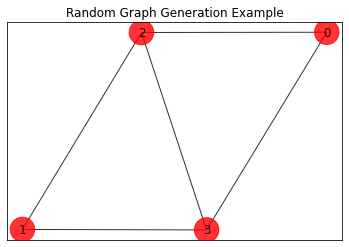

In [28]:
n = 4
p = 0.95
G = ER(n, p)
pos = nx.spring_layout(G)
plot_result(G,[0]*n)
plt.title("Random Graph Generation Example") 
edges = G.edges
e = np.array(list(edges))

print(n)
quantum_wo_penalty()

In [22]:
from qiskit.tools.monitor import job_monitor

1
classical_wo_penalty:  0.09863924980163574
classical_w_penalty:  0.047145843505859375


NameError: name 'qp_wo_constr' is not defined

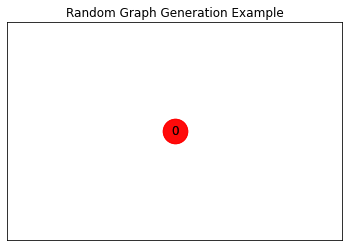

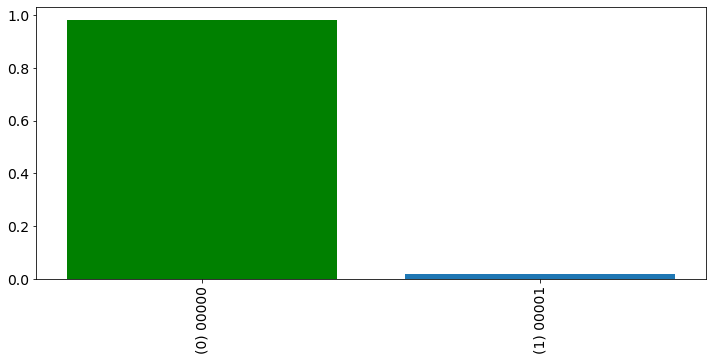

In [8]:
for i in range(1, 15):
        n = i
        p = 0.95
        G = ER(n, p)
        pos = nx.spring_layout(G)
        plot_result(G,[0]*n)
        plt.title("Random Graph Generation Example") 
        edges = G.edges
        e = np.array(list(edges))
        
        print(n)
        classical_wo_penalty()
#         quantum_wo_penalty()
        classical_w_penalty()
        quantum_w_penalty()

In [4]:
######## Without Penalty  #######
######## Solve Quadratic Program using CPLEX######
def classical_wo_penalty():
        start = time.time()
        mdl = Model('Vertex cover')
        x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdl.sum([ (x[i] ) for i in range(n)])
        mdl.minimize(objective)
        for (i,j) in edges:
            subjective = mdl.sum([x[i]+x[j]])
            mdl.add_constraint(subjective >=1)
        #mdl.prettyprint()
        # convert from DOcplex model to Qiskit Quadratic Program
        qp = QuadraticProgram()
        qp.from_docplex(mdl)

        cplex = CplexOptimizer()
        result = cplex.solve(qp)
        #print(result)
        plot_result(G, result.x)

        end = time.time()
        print("classical_wo_penalty: ", end - start)
        time_list[0].append(end - start)

In [27]:
######## Solve Quadratic Program using QAOA######
def quantum_wo_penalty():
        start = time.time()
        m = n +int(e.size/2)
        mdl = Model('Vertex cover')
        x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdl.sum([ (x[i] ) for i in range(n)])
        mdl.minimize(objective)
        for (i,j) in edges:
            subjective = mdl.sum([x[i]+x[j]])
            mdl.add_constraint(subjective >=1)
#         mdl.prettyprint()

        # convert from DOcplex model to Qiskit Quadratic Program
        qp = QuadraticProgram()
        qp.from_docplex(mdl)
        lineq2penalty = LinearEqualityToPenalty(penalty = 1)
        ITE = InequalityToEquality('integer')
        ITB = IntegerToBinary()
        qp = ITB.convert(qp)
        qpc = ITE.convert(qp)
        qp_wo_constr = lineq2penalty.convert(qpc)
        qubo = QuadraticProgramToQubo()
        qp_wo_constr = qubo.convert(qp_wo_constr)

        H, offset = qp_wo_constr.to_ising()

        H_matrix = np.real(H.to_matrix(massive=True))
        # plot diagonal of matrix
        opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0] 

        # construct parameters from annealing schedule
        T = 10
        N = 20
        gammas, betas = construct_schedule(T, N)

        # construct variational form
        var_form = QAOAVarForm(H, N+1)

        # evaluate circuit
        qc = var_form.construct_circuit(gammas + betas)
        sv = Statevector.from_instruction(qc)
        # plot probabilities
        probabilities = sv.probabilities()
#         plt.figure(figsize=(12, 5))
#         plt.bar(range(2**m), probabilities)
#         plt.bar(opt_indices, probabilities[opt_indices], color='g')
#         plt.xticks(range(2**m), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**m)], rotation=90, fontsize=14)
#         plt.yticks(fontsize=14);
        gamma, beta = Parameter('gamma'), Parameter('beta')
        p = 1
        var_form = QAOAVarForm(H, p)
#         var_form.construct_circuit([gamma, beta]).draw('mpl')
        circuit=vary_form.construct_circuit()
        optimizer = COBYLA()

#         qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
        print(1)
        qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance = backend)
        print(2)
        qaoa_mes
        result = qaoa_mes.execute()
        job_monitor(result)
        print(3)
#         print('optimal params:      ', result.optimal_parameters)
#         print('optimal value:       ', result.optimal_value)
#         print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))
        # construct QAOA as Minimum Eigensolver
        qaoa_mes = QAOA(p=1, optimizer=optimizer, quantum_instance = backend)
        # construct Minimum Eigen Optimizer based on QAOA
        qaoa = MinimumEigenOptimizer(qaoa_mes)

        # solve Quadratic Program
        result = qaoa.solve(qp_wo_constr)
        print(4)
        end = time.time()
#         print(result)
        plot_result(G, result.x)
        print("quantum_wo_penalty: ", end - start)
        time_list[1].append(end - start)

In [6]:
######## With Penalty  #######
######## Solve Quadratic Program using CPLEX######
def classical_w_penalty():
        start = time.time()
        penalty = (e.size+n)/2
        mdlp = Model('Vertex cover')
        x = mdlp.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdlp.sum([ (x[i] ) for i in range(n)])
        subtoobj = mdlp.sum([(1 - x[i]-x[j]+2*x[i]*x[j]) for (i,j) in edges])
        objective1 = mdlp.sum([objective,penalty*subtoobj])

        mdlp.minimize(objective1)
#         mdlp.rettyprint()
        # convert from DOcplex model to Qiskit Quadratic Program
        qp = QuadraticProgram()
        qp.from_docplex(mdlp)

        cplex = CplexOptimizer()
        result = cplex.solve(qp)
        end = time.time()
        
#         plot_result(G, result.x)
        print("classical_w_penalty: ", end - start)
        time_list[2].append(end - start)

In [7]:
######## With Penalty  #######
######## Solve Quadratic Program using QAOA######
def quantum_w_penalty():
        start = time.time()
        mdlp = Model('Vertex cover')
        penalty = (e.size+n)/2
        x = mdlp.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdlp.sum([ (x[i] ) for i in range(n)])
        subtoobj = mdlp.sum([(1 - x[i]-x[j]+2*x[i]*x[j]) for (i,j) in edges])
        objective1 = mdlp.sum([objective, penalty*subtoobj])

        mdlp.minimize(objective1)
#         mdlp.prettyprint()
        # convert from DOcplex model to Qiskit Quadratic Program
        qp = QuadraticProgram()
        qp.from_docplex(mdlp)



        H, offset = qp.to_ising()
        H_matrix = np.real(H.to_matrix(massive=True))

        # plot diagonal of matrix
        opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]


        # construct parameters from annealing schedule
        T = 10
        N = 20
        gammas, betas = construct_schedule(T, N)

        # construct variational form
        var_form = QAOAVarForm(H, N+1)

        # evaluate circuit
        qc = var_form.construct_circuit(gammas + betas)
        sv = Statevector.from_instruction(qc)
        # plot probabilities
        probabilities = sv.probabilities()
        plt.figure(figsize=(12, 5))
        plt.bar(range(2**n), probabilities)
        plt.bar(opt_indices, probabilities[opt_indices], color='g')
        plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
        plt.yticks(fontsize=14);
        gamma, beta = Parameter('gamma'), Parameter('beta')
        p = 1
        var_form = QAOAVarForm(H, p)
        #var_form.construct_circuit([gamma, beta]).draw('mpl')

        optimizer = COBYLA()

        qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
        result = qaoa_mes.run()

#         print('optimal params:      ', result.optimal_parameters)
#         print('optimal value:       ', result.optimal_value)
#         print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))
        # construct QAOA as Minimum Eigensolver
        qaoa_mes = QAOA(p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

        # construct Minimum Eigen Optimizer based on QAOA
        qaoa = MinimumEigenOptimizer(qaoa_mes)

        # solve Quadratic Program
        result = qaoa.solve(qp_wo_constr)
        end = time.time()
        print("quantum_w_penalty: ", end - start)
        time_list[3].append(end - start)
        plot_result(G, result.x)

In [12]:
from qiskit import IBMQ, assemble, transpile

provider = IBMQ.enable_account('f8181846e31bc3f1483e27d4d5400de54ac5b61706a9e33c0763c78c85668c650cd9fff24eefa4209912dee7800080c16e13bb54d63931847fdf04c2150aa886')

backends = provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [13]:
backend = provider.get_backend('ibmq_16_melbourne')
backend

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>